<a href="https://colab.research.google.com/github/avinash273/Connect-Components-graph-mapreduce/blob/master/GoogleInceptionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step


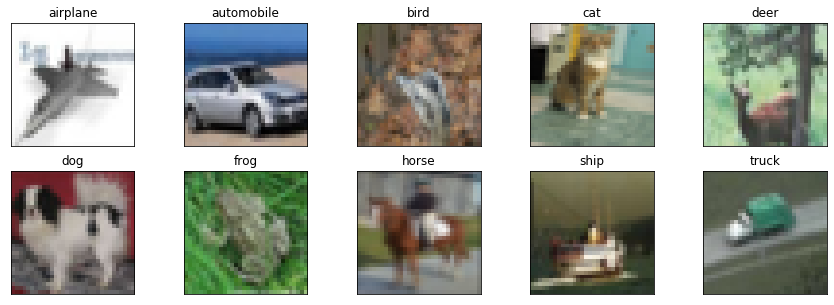














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
inception_1_/3x3_reduce (Conv2D (None, 32, 32, 96)   384         input[0][0]                      
__________________________________________________________________________________________________
inception_1_/5x5_reduce (Conv2D (None, 32, 32, 16)   64          input[0][0]                      
__________________________________________________________________________________________________
inception_1_/pool (MaxPooling2D (None, 32, 32, 3)    0       

Text(0.5, 1.0, 'Loss Curve')

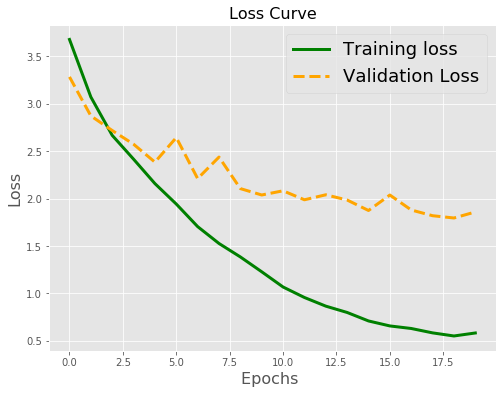

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 15 16:41:16 2019

@author: avinashshanker
"""
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
# # Load the TensorBoard notebook extension
# %tensorflow_version 2.x
%load_ext tensorboard

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 15 16:41:16 2019

@author: avinashshanker
"""
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import warnings
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import datetime
from keras.layers import Flatten, Activation, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Flatten, Activation, Conv2D, AvgPool2D, Dense, Dropout, concatenate, AveragePooling2D
from keras.optimizers import Adam, SGD
from keras.models import Sequential
import keras.backend as K
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json, Model
from keras.utils.np_utils import to_categorical

warnings.filterwarnings('ignore')
np.random.seed(390)

#import CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Show classes of input dataset
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
nClasses = 10
fig = plt.figure(figsize=(15,5))
for i in range(nClasses):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

#Converting to float32 data type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#This is temporary to slice while running on CPU, On GPU please comment
x_train = x_train[0:5000]
x_test = x_test[0:5000]
y_test = y_test[0:5000]
y_train = y_train[0:5000]

#normalization of Training dataset
# mean = np.mean(x_train,axis=(0,1,2,3))
# std = np.std(x_train,axis=(0,1,2,3))
# x_train = (x_train-mean)/(std+1e-7)
# x_test = (x_test-mean)/(std+1e-7)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

def CreateDense(input_layer, neurons_nr, dense_nr, dropout=False, normalization=False, regularization='l2', dropout_ratio=0.5):
    dense = Dense(neurons_nr, kernel_regularizer=regularization, name='dense_%d_%d'%(dense_nr, neurons_nr))(input_layer)
    
    if dropout:
        dense = Dropout(dropout_ratio, name='dense_%d_%ddrop'%(dense_nr, neurons_nr))(dense)
    if normalization:
        dense = BatchNormalization(name='dense_%d_%dnorm'%(dense_nr, neurons_nr))(dense)
    
    return dense

def InceptionLayer(input_layer, features_nr, module_nr, dropout=False, normalization=False, regularization='l2', dropout_ratio=0.2):  
  
    inception_1x1 = Conv2D(features_nr[0],1,1,border_mode='same',activation='relu',name='inception_%d_/1x1'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    inception_3x3_reduce = Conv2D(features_nr[1],1,1,border_mode='same',activation='relu',name='inception_%d_/3x3_reduce'%(module_nr),W_regularizer=l2(0.0002))(input_layer)    
    inception_3x3 = Conv2D(features_nr[2],3,3,border_mode='same',activation='relu',name='inception_%d_/3x3'%(module_nr),W_regularizer=l2(0.0002))(inception_3x3_reduce)    
    inception_5x5_reduce = Conv2D(features_nr[3],1,1,border_mode='same',activation='relu',name='inception_%d_/5x5_reduce'%(module_nr),W_regularizer=l2(0.0002))(input_layer)   
    inception_5x5 = Conv2D(features_nr[4],5,5,border_mode='same',activation='relu',name='inception_%d_/5x5'%(module_nr),W_regularizer=l2(0.0002))(inception_5x5_reduce)    
    inception_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),border_mode='same',name='inception_%d_/pool'%(module_nr))(input_layer)    
    inception_pool_proj = Conv2D(features_nr[5],1,1,border_mode='same',activation='relu',name='inception_%d_/pool_proj'%(module_nr),W_regularizer=l2(0.0002))(inception_pool)   
    inception_output = concatenate([inception_1x1,inception_3x3,inception_5x5,inception_pool_proj],axis=3,name='inception_%d_/output'%(module_nr))

    if dropout:
        inception_output = Dropout(dropout_ratio, name='inception_%d_/output_drop'%(module_nr))(inception_output)
    if normalization:
        inception_output = BatchNormalization(name='inception_%d_/output_norm'%(module_nr))(inception_output)

    pooled = MaxPooling2D((2,2), padding='same', name='inception_%d_2x2subsample'%(module_nr))(inception_output)
    
    return pooled



use_norm = True
lrate = 0.001
import keras
input_img = keras.layers.Input(shape = (32, 32, 3), name='input')
inception_1 = InceptionLayer(input_img, [64,96,128,16,32,32], 1, False, use_norm)
inception_2 = InceptionLayer(inception_1, [128,128,192,32,96,64], 2, False, use_norm)
inception_3 = InceptionLayer(inception_2, [192,96,208,16,48,64], 3, False, use_norm)
inception_4 = InceptionLayer(inception_3, [160, 112, 224, 24, 64, 64], 4, False, use_norm)


flat_pool = AveragePooling2D(pool_size=(2, 2), padding='valid')(inception_4)

flat = Flatten()(flat_pool)

dense_6 = CreateDense(flat, 64, 2, True, use_norm)

out = Dense(10, activation='softmax')(dense_6)

model = Model(inputs = input_img, outputs = out)

# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(lrate),
#               #metrics=['top_k_categorical_accuracy']
#               metrics=['top_k_categorical_accuracy'])

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy','top_k_categorical_accuracy'])

model.summary()

name = "inception-{}".format(datetime.datetime.now())

a = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
#b = ModelCheckpoint(monitor='val_loss', filepath='./models/'+str(i)+'.hdf5', verbose=1, save_best_only=True)
c = TensorBoard(log_dir = os.path.join(
    "topk",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
                write_grads=True,
                write_graph=True,
                write_images=True,
                batch_size=128)

d = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[a,c,d]


history = model.fit(x_train, y_train_cat, batch_size=128, epochs=20, validation_split=0.2,verbose=1,callbacks=callbacks)
!cp -R logs my_drive/Colab\ Notebooks/cifar10 

# Loss Curves
plt.style.use('ggplot')
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'green',linewidth=3.0)
plt.plot(history.history['val_loss'],'orange',ls = '--', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curve',fontsize=16)


In [0]:
#Accuracy Curve
plt.style.use('ggplot')
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'red',linewidth=3.0)
plt.plot(history.history['val_acc'],'blue',ls = '--',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18, loc = 'lower right')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


score = model.evaluate(x_test, y_test_cat, verbose=1)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

In [0]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test_cat,axis=1),y_pred)[ix].sum())
confusion_matrix = confusion_matrix(np.argmax(y_test_cat,axis=1),y_pred)
print(confusion_matrix)

In [0]:
figure = plt.figure(figsize=(10, 10))
import seaborn as sns
sns.heatmap(confusion_matrix,  annot=True, fmt="d", cmap='YlGnBu')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [0]:
%tensorboard --logdir topk
